# Reproduction

## Set-up

Import required packages

In [1]:
# Import model
import model

# Data processing and figure generation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Manage file paths
from dataclasses import dataclass
import os

# Hide warnings that appear
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.filterwarnings('ignore')

# Import and start timer (used to record runtime of this notebook)
import time
start = time.time()

Set file paths

In [2]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    outputs = '../outputs'
    base_5 = 'output_base5.csv'
    base_15 = 'output_base15.csv'
    base_30 = 'output_base30.csv'

    paper = '../../original_study'
    tab2 = 'supp_tab2_reformat.csv'
    tab3 = 'supp_tab3_reformat.csv'
    tab4 = 'supp_tab4_reformat.csv'
    tab5 = 'supp_tab5_reformat.csv'
    tab6 = 'supp_tab6_reformat.csv'
    fig2 = 'fig2.png'
    fig3 = 'fig3.png'

paths = Paths()

## Run model

Base scenario with 15% probability of secondary infection

In [3]:
# Run model
# res = model.run_scenarios()

# Save results to CSV
# res.to_csv(os.path.join(paths.outputs, paths.base_15), index=False)

Base scenario with 5% probability of secondary infection

In [4]:
# Run model
# res = model.run_scenarios(secondary_attack_rate=0.05)

# Save results to CSV
# res.to_csv(os.path.join(paths.outputs, paths.base_5), index=False)

Base scenario with 30% probability of secondary infection

In [5]:
# Run model
# res = model.run_scenarios(secondary_attack_rate=0.3)

# Save results to CSV
# res.to_csv(os.path.join(paths.outputs, paths.base_30), index=False)

## Import results

In [6]:
model_base15 = pd.read_csv(os.path.join(paths.outputs, paths.base_15))
paper_tab2 = pd.read_csv(os.path.join(paths.paper, paths.tab2))

model_base5 = pd.read_csv(os.path.join(paths.outputs, paths.base_5))
paper_tab3 = pd.read_csv(os.path.join(paths.paper, paths.tab3))

model_base30 = pd.read_csv(os.path.join(paths.outputs, paths.base_30))
paper_tab4 = pd.read_csv(os.path.join(paths.paper, paths.tab4))

## Function to compare tables

In [7]:
def compare_tables(model_tab, paper_tab):
    '''
    Combine the model and paper tables into single dataframe with a diff column

    Parameters:
    -----------
    model_tab : dataframe
        Raw output from model
    paper_tab : dataframe
        Reformatted table from supplementary materials
    '''
    # Merge the dataframes
    comp = pd.merge(
        model_tab.rename(columns={'prop_infected': 'prop_infected_model'}),
        paper_tab.rename(columns={'prop_infected': 'prop_infected_paper'}))

    # Calculate difference
    comp['diff'] = abs(comp['prop_infected_model'] -
                       comp['prop_infected_paper'])

    return comp

## Examine differences in supplementary tables 2, 3 and 4

Supplementary table 2

In [8]:
# Get table 2 and save to csv
model_tab2 = model_base15[model_base15['end_of_day'].isin([7, 14, 21])]
model_tab2.to_csv(os.path.join(paths.outputs, paths.tab2), index=False)

In [9]:
# Combine model results alongside results from paper
t2_comp = compare_tables(model_tab2, paper_tab2)

# Descriptive statistics for absolute difference in results
print(t2_comp['diff'].describe())

# Extracting instances where absolute difference is more than 0.05
display(t2_comp[t2_comp['diff'] > 0.05])

count    420.000000
mean       0.008571
std        0.016976
min        0.000000
25%        0.000000
50%        0.000000
75%        0.010000
max        0.100000
Name: diff, dtype: float64


,strength,staff_change,staff_per_shift,shifts_per_day,end_of_day,prop_infected_model,prop_infected_paper,diff
24,2,7,5,1,7,0.40,0.30,0.10
96,4,14,5,1,7,0.15,0.20,0.05
97,4,14,5,2,7,0.15,0.20,0.05
98,4,14,5,3,7,0.15,0.20,0.05
110,4,21,5,3,7,0.20,0.15,0.05
180,2,1,5,1,14,0.40,0.30,0.10
204,2,7,5,1,14,0.40,0.30,0.10
243,4,1,10,1,14,0.12,0.17,0.05
247,4,1,20,2,14,0.35,0.41,0.06
254,4,3,5,3,14,0.15,0.20,0.05


Supplementary table 3

In [10]:
# Get table 3 and save to csv
model_tab3 = model_base5[model_base5['end_of_day'].isin([7, 14, 21])]
model_tab3.to_csv(os.path.join(paths.outputs, paths.tab3), index=False)

In [11]:
# Combine tables
t3_comp = compare_tables(model_tab3, paper_tab3)

# Descriptive statistics for absolute difference in results
print(t3_comp['diff'].describe())

# Extracting instances where absolute difference is more than 0.05
display(t3_comp[t3_comp['diff'] > 0.05])

count    420.000000
mean       0.010119
std        0.017154
min        0.000000
25%        0.000000
50%        0.000000
75%        0.020000
max        0.100000
Name: diff, dtype: float64


,strength,staff_change,staff_per_shift,shifts_per_day,end_of_day,prop_infected_model,prop_infected_paper,diff
24,2,7,5,1,7,0.10,0.20,0.10
30,2,7,20,1,7,0.15,0.20,0.05
36,2,14,5,1,7,0.20,0.10,0.10
180,2,1,5,1,14,0.20,0.10,0.10
204,2,7,5,1,14,0.10,0.20,0.10
210,2,7,20,1,14,0.15,0.20,0.05
228,2,21,5,1,14,0.20,0.30,0.10
372,2,3,5,1,21,0.30,0.20,0.10
443,4,3,30,3,21,0.23,0.28,0.05
468,4,21,5,1,21,0.15,0.20,0.05


Supplementary table 4

In [12]:
# Get table 4 and save to csv
model_tab4 = model_base30[model_base30['end_of_day'].isin([7, 14, 21])]
model_tab4.to_csv(os.path.join(paths.outputs, paths.tab4), index=False)

In [13]:
# Combine tables
t4_comp = compare_tables(model_tab4, paper_tab4)

# Descriptive statistics for absolute difference in results
print(t4_comp['diff'].describe())

# Extracting instances where absolute difference is more than 0.05
display(t4_comp[t4_comp['diff'] > 0.05])

count    420.000000
mean       0.004929
std        0.012860
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.100000
Name: diff, dtype: float64


,strength,staff_change,staff_per_shift,shifts_per_day,end_of_day,prop_infected_model,prop_infected_paper,diff
0,2,1,5,1,7,0.30,0.40,0.10
12,2,3,5,1,7,0.40,0.30,0.10
72,4,3,5,1,7,0.15,0.20,0.05
73,4,3,5,2,7,0.15,0.20,0.05
74,4,3,5,3,7,0.20,0.15,0.05
421,4,1,5,2,21,0.55,0.65,0.10
494,6,3,5,3,21,0.27,0.33,0.06


## Figures

Define function to create the subplots

In [14]:
def plot_fig(fig_dict_list, ax, letter, title,
             ylabel='Proportion of staff infected', legend=True):
    '''
    Create one of the subplots from the article's figures.

    Parameters:
    -----------
    fig_dict_list : list
        List of dictionaries with parameters to filter dataframe by and for
        formatting the figure
    ax : axes object
        To create the plot on
    letter : string
        Letter of subplot (e.g. '(a)', '(b)')
    title : string
        Title for the subplot
    ylabel : string
        Title for Y axis
    legend : boolean
        Whether to include a figure legend for that subplot
    '''
    # Create each of the line plots
    for fig_dict in fig_dict_list:

        # Get the filters for the dataframe
        filt = {key: fig_dict[key] for key in [
            'shifts_per_day', 'staff_per_shift', 'strength', 'staff_change']}

        # Get subset of dataframe meeting the conditions
        query = ' & '.join([f"{col} == {val}" for col, val in filt.items()])
        subset = fig_dict['df'].query(query)

        # Reformat so ready to plot
        to_plot = subset.set_index('end_of_day')['prop_infected']

        # Plot on ax
        ax.plot(to_plot, label=fig_dict['label'], color=fig_dict['color'],
                linestyle=fig_dict['linestyle'], linewidth=3)

    # Formatting the figure to match the paper
    ax.set_title(title)
    ax.set_xlabel('Day')
    ax.set_xticks(np.arange(0, 21, 5))
    ax.set_ylabel(ylabel)
    ax.set_ylim(0, 1)
    if legend == True:
        ax.legend(loc='upper left')
    ax.annotate(letter, xy=(-0.15, 1.1), xycoords='axes fraction')
    ax.grid()

### Figure 2

Set out parameters for each of the lines

In [15]:
fig2a_black = {
    'shifts_per_day': 1,
    'staff_per_shift': 30,
    'strength': 2,
    'staff_change': 1,
    'df': model_base15,
    'label': '2 x 30 staff/shift',
    'color': 'black',
    'linestyle': '-'
}

fig2a_green = {
    'shifts_per_day': 1,
    'staff_per_shift': 10,
    'strength': 6,
    'staff_change': 1,
    'df': model_base15,
    'label': '6 x 10 staff/shift',
    'color': '#94B454',
    'linestyle': '--'
}

fig2b_black = {
    'shifts_per_day': 2,
    'staff_per_shift': 30,
    'strength': 4,
    'staff_change': 1,
    'df': model_base15,
    'label': '4 x 30 staff/shift',
    'color': 'black',
    'linestyle': '-'
}

fig2b_green = {
    'shifts_per_day': 2,
    'staff_per_shift': 20,
    'strength': 6,
    'staff_change': 1,
    'df': model_base15,
    'label': '6 x 20 staff/shift',
    'color': '#94B454',
    'linestyle': '--'
}

fig2c_black = {
    'shifts_per_day': 3,
    'staff_per_shift': 30,
    'strength': 4,
    'staff_change': 1,
    'df': model_base15,
    'label': '4 x 30 staff/shift',
    'color': 'black',
    'linestyle': '-'
}

fig2c_green = {
    'shifts_per_day': 3,
    'staff_per_shift': 20,
    'strength': 6,
    'staff_change': 1,
    'df': model_base15,
    'label': '6 x 20 staff/shift',
    'color': '#94B454',
    'linestyle': '--'
}

fig2d_blue = {
    'shifts_per_day': 2,
    'staff_per_shift': 30,
    'strength': 4,
    'staff_change': 1,
    'df': model_base5,
    'label': '5%',
    'color': '#0D5BB7',
    'linestyle': ':'
}

fig2d_black = {
    'shifts_per_day': 2,
    'staff_per_shift': 30,
    'strength': 4,
    'staff_change': 1,
    'df': model_base15,
    'label': '15%',
    'color': 'black',
    'linestyle': '-'
}

fig2d_red = {
    'shifts_per_day': 2,
    'staff_per_shift': 30,
    'strength': 4,
    'staff_change': 1,
    'df': model_base30,
    'label': '3%',
    'color': '#C14C46',
    'linestyle': '--'
}

Create the figure

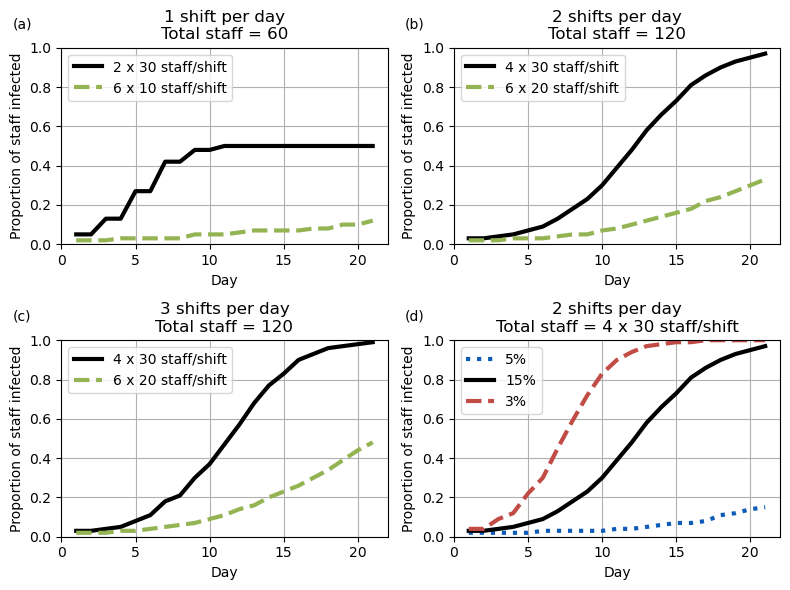

In [16]:
# Set up number of subplots and figure size
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

# Create the subplots
plot_fig([fig2a_black, fig2a_green], ax[0,0], letter='(a)',
          title='1 shift per day\nTotal staff = 60')
plot_fig([fig2b_black, fig2b_green], ax[0,1], letter='(b)',
          title='2 shifts per day\nTotal staff = 120')
plot_fig([fig2c_black, fig2c_green], ax[1,0], letter='(c)',
          title='3 shifts per day\nTotal staff = 120')
plot_fig([fig2d_blue, fig2d_black, fig2d_red], ax[1,1], letter='(d)',
          title='2 shifts per day\nTotal staff = 4 x 30 staff/shift')

# Prevent overlap between subplots
fig.tight_layout()

# Save the figure
plt.savefig(os.path.join(paths.outputs, paths.fig2))

# Display the figure
plt.show()

### Figure 3

Formatting for each of the four lines (which are the same for each subplot)

In [17]:
fig3_lines = [
    # Black line
    {
        'staff_per_shift': 5,
        'label': '5 staff/shift',
        'color': 'black',
        'linestyle': '-'
    },
    # Green line
    {
        'staff_per_shift': 10,
        'label': '10 staff/shift',
        'color': '#94B454',
        'linestyle': '--'
    },
    # Purple line
    {
        'staff_per_shift': 20,
        'label': '20 staff/shift',
        'color': '#7F619D',
        'linestyle': ':'
    },
    # Red line
    {
        'staff_per_shift': 30,
        'label': '30 staff/shift',
        'color': '#C14C46',
        'linestyle': '-'
    }
]

Set default parameters for each subplot

In [18]:
all_fig3 = {
    'staff_change': 1,
    'df': model_base15
}

all_fig3a = {
    'shifts_per_day': 1,
    'strength': 4
}

all_fig3b = {
    'shifts_per_day': 1,
    'strength': 6
}

all_fig3c = {
    'shifts_per_day': 2,
    'strength': 4
}

all_fig3d = {
    'shifts_per_day': 2,
    'strength': 6
}

all_fig3e = {
    'shifts_per_day': 3,
    'strength': 4
}

all_fig3f = {
    'shifts_per_day': 3,
    'strength': 6
}

Combine dictionaries to get conditions for plots

In [19]:
fig3a = [{**all_fig3, **all_fig3a, **x} for x in fig3_lines]
fig3b = [{**all_fig3, **all_fig3b, **x} for x in fig3_lines]
fig3c = [{**all_fig3, **all_fig3c, **x} for x in fig3_lines]
fig3d = [{**all_fig3, **all_fig3d, **x} for x in fig3_lines]
fig3e = [{**all_fig3, **all_fig3e, **x} for x in fig3_lines]
fig3f = [{**all_fig3, **all_fig3f, **x} for x in fig3_lines]

Create the plot

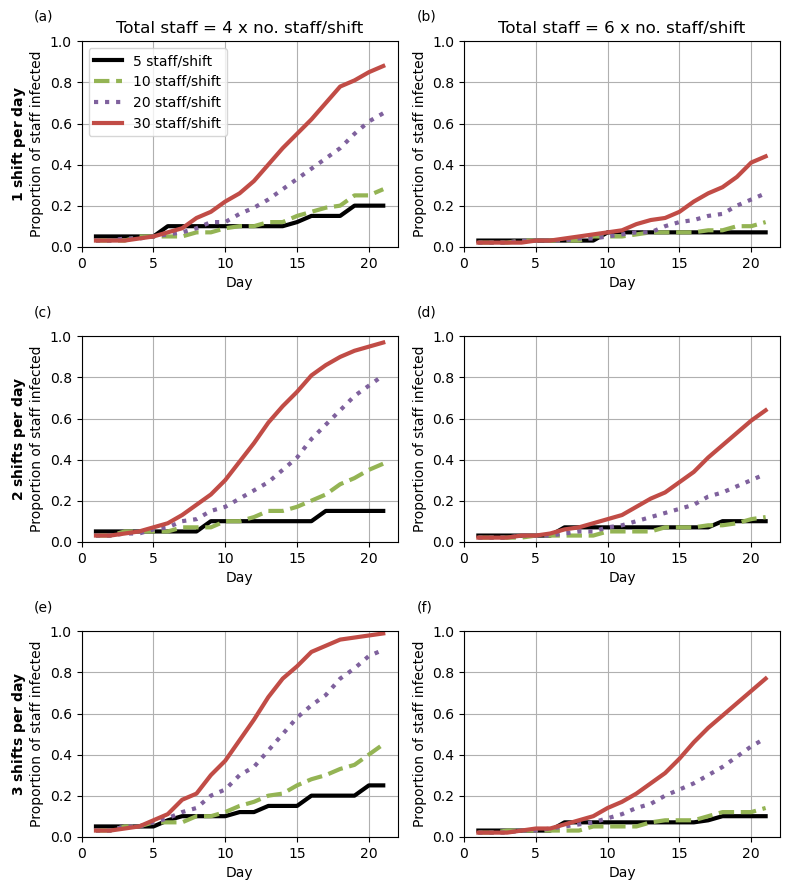

In [20]:
# Set up number of subplots and figure size
fig, ax = plt.subplots(3, 2, figsize=(8, 9))

plot_fig(fig3a, ax[0,0], title='Total staff = 4 x no. staff/shift',
         letter='(a)',
         ylabel='$\\bf{1\ shift\ per\ day}$\nProportion of staff infected')

plot_fig(fig3b, ax[0,1], letter='(b)',
         title='Total staff = 6 x no. staff/shift', legend=False)

plot_fig(fig3c, ax[1,0], letter='(c)', title='',
         ylabel='$\\bf{2\ shifts\ per\ day}$\nProportion of staff infected',
         legend=False)

plot_fig(fig3d, ax[1,1], letter='(d)', title='', legend=False)

plot_fig(fig3e, ax[2,0], letter='(e)', title='',
         ylabel='$\\bf{3\ shifts\ per\ day}$\nProportion of staff infected',
         legend=False)

plot_fig(fig3f, ax[2,1], letter='(f)', title='', legend=False)

# Prevent overlap between subplots
fig.tight_layout()

# Save the figure
plt.savefig(os.path.join(paths.outputs, paths.fig3))

# Display the figure
plt.show()

## Time elapsed

In [21]:
# Find run time in seconds
end = time.time()
runtime = round(end-start)

# Display converted to minutes and seconds
print(f'Notebook run time: {runtime//60}m {runtime%60}s')

Notebook run time: 0m 3s
